In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Average True Range (ATR)

In [20]:
def calculate_atr(price_data, window=14):
    """
    Calculate ATR (Average True Range) using Wilder's RMA.

    Args:
        price_data (pd.DataFrame): DataFrame containing columns 'high', 'low', 'close'
        window (int): Lookback period (default: 14)

    Returns:
        pd.Series: ATR values
    """
    high = price_data['high']
    low = price_data['low']
    close = price_data['close']

    # Calculate True Range (TR)
    previous_close = close.shift(1)
    tr1 = high - low
    tr2 = abs(high - previous_close)
    tr3 = abs(low - previous_close)
    true_range = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)

    # ATR = RMA of True Range
    atr = true_range.ewm(alpha=1/window, adjust=False).mean()

    return atr

## Zigzag-ATR

In [21]:
def atr_zigzag_two_columns(df, atr_col="atr", close_col="close", atr_mult=1):
    """
    ATR bazlı strict zigzag, high ve low pivotları ayrı sütunlarda.
    Ayrıca pivot teyidi hangi barda geldiğini ve kaç bar geciktiğini işaretler.
    NaN değerler son pivot değerleriyle doldurulur.
    Pivot oluştuğu andaki ATR değerleri de korunur.

    Params:
        df : DataFrame
        atr_col : str -> ATR kolon adı
        close_col : str -> Kapanış fiyatı kolon adı
        atr_mult : float -> Kaç ATR kullanılacak (1, 2, 3 ...)
    """
    closes = df[close_col].values
    atrs = df[atr_col].values

    high_pivot = [None] * len(df)
    low_pivot = [None] * len(df)
    high_pivot_atr = [None] * len(df)  # ATR değerini sakla
    low_pivot_atr = [None] * len(df)   # ATR değerini sakla
    high_pivot_confirmed = [0] * len(df)
    low_pivot_confirmed = [0] * len(df)
    pivot_bars_ago = [None] * len(df)

    last_pivot = closes[0]
    last_atr = atrs[0]
    last_pivot_idx = 0
    direction = None  # "up" veya "down"

    for i in range(1, len(df)):
        price = closes[i]
        atr = atrs[i] * atr_mult  # ATR çarpanı uygulanıyor

        if direction is None:
            if price >= last_pivot + atr:
                direction = "up"
                last_pivot = closes[last_pivot_idx]
                high_pivot[last_pivot_idx] = last_pivot
                high_pivot_atr[last_pivot_idx] = atrs[last_pivot_idx]  # ATR değerini kaydet
            elif price <= last_pivot - atr:
                direction = "down"
                last_pivot = closes[last_pivot_idx]
                low_pivot[last_pivot_idx] = last_pivot
                low_pivot_atr[last_pivot_idx] = atrs[last_pivot_idx]   # ATR değerini kaydet

        elif direction == "up":
            if price <= (last_pivot - atr):
                # ✅ Tepe teyit edildi
                high_pivot[last_pivot_idx] = last_pivot
                high_pivot_atr[last_pivot_idx] = atrs[last_pivot_idx]  # ATR değerini kaydet
                high_pivot_confirmed[i] = 1
                pivot_bars_ago[i] = i - last_pivot_idx

                direction = "down"
                last_pivot = price
                last_pivot_idx = i
            elif price > last_pivot:
                # Tepe güncelle, teyit etme
                last_pivot = price
                last_pivot_idx = i

        elif direction == "down":
            if price >= (last_pivot + atr):
                # ✅ Dip teyit edildi
                low_pivot[last_pivot_idx] = last_pivot
                low_pivot_atr[last_pivot_idx] = atrs[last_pivot_idx]   # ATR değerini kaydet
                low_pivot_confirmed[i] = 1
                pivot_bars_ago[i] = i - last_pivot_idx

                direction = "up"
                last_pivot = price
                last_pivot_idx = i
            elif price < last_pivot:
                # Dip güncelle, teyit etme
                last_pivot = price
                last_pivot_idx = i

    # Önce orijinal sütunları oluştur
    df["high_pivot"] = high_pivot
    df["low_pivot"] = low_pivot
    df["high_pivot_atr"] = high_pivot_atr
    df["low_pivot_atr"] = low_pivot_atr
    df["high_pivot_confirmed"] = high_pivot_confirmed
    df["low_pivot_confirmed"] = low_pivot_confirmed
    df["pivot_bars_ago"] = pivot_bars_ago

    # NaN değerleri doldurma işlemleri
    # high_pivot ve low_pivot için forward fill
    df["high_pivot_filled"] = df["high_pivot"].ffill()
    df["low_pivot_filled"] = df["low_pivot"].ffill()

    # ATR değerleri için de forward fill
    df["high_pivot_atr_filled"] = df["high_pivot_atr"].ffill()
    df["low_pivot_atr_filled"] = df["low_pivot_atr"].ffill()

    # high_pivot_confirmed ve low_pivot_confirmed için forward fill
    # Burada 0/1 değerlerini korumak için özel bir yaklaşım
    df["high_pivot_confirmed_filled"] = df["high_pivot_confirmed"].replace(to_replace=0, value=None).ffill().fillna(0).astype(int)
    df["low_pivot_confirmed_filled"] = df["low_pivot_confirmed"].replace(to_replace=0, value=None).ffill().fillna(0).astype(int)

    # pivot_bars_ago için özel doldurma - her satırda 1 artırarak
    pivot_bars_filled = []
    last_valid_value = None
    last_valid_index = None

    for i, value in enumerate(pivot_bars_ago):
        if value is not None:
            last_valid_value = value
            last_valid_index = i
            pivot_bars_filled.append(value)
        elif last_valid_value is not None:
            # NaN değeri, son geçerli değer + (mevcut index - son geçerli index)
            new_value = last_valid_value + (i - last_valid_index)
            pivot_bars_filled.append(new_value)
        else:
            # İlk değerler için
            pivot_bars_filled.append(None)

    df["pivot_bars_ago_filled"] = pivot_bars_filled

    return df

## Zigzag High - Low ATR

In [22]:
def atr_zigzag_high_low_two_columns(df, atr_col="atr", close_col="close", high_col="high", low_col="low", atr_mult=1):
    """
    ATR bazlı strict zigzag, high ve low pivotları ayrı sütunlarda.
    High pivotları high sütunundan, low pivotları low sütunundan belirler.
    Teyitler close fiyatına göre yapılır.
    Ayrıca pivot teyidi hangi barda geldiğini ve kaç bar geciktiğini işaretler.
    NaN değerler son pivot değerleriyle doldurulur.
    Pivot oluştuğu andaki ATR değerleri de korunur.

    Params:
        df : DataFrame
        atr_col : str -> ATR kolon adı
        close_col : str -> Kapanış fiyatı kolon adı (teyit için)
        high_col : str -> High fiyatı kolon adı (high pivot için)
        low_col : str -> Low fiyatı kolon adı (low pivot için)
        atr_mult : float -> Kaç ATR kullanılacak (1, 2, 3 ...)
    """
    closes = df[close_col].values
    highs = df[high_col].values
    lows = df[low_col].values
    atrs = df[atr_col].values

    high_pivot = [None] * len(df)
    low_pivot = [None] * len(df)
    high_pivot_atr = [None] * len(df)
    low_pivot_atr = [None] * len(df)
    high_pivot_confirmed = [0] * len(df)
    low_pivot_confirmed = [0] * len(df)
    pivot_bars_ago = [None] * len(df)

    last_high_pivot = highs[0]
    last_low_pivot = lows[0]
    last_pivot_idx = 0
    last_atr = atrs[0]
    direction = None  # "up" veya "down"

    for i in range(1, len(df)):
        close = closes[i]
        high = highs[i]
        low = lows[i]
        atr = atrs[i] * atr_mult

        if direction is None:
            # İlk yön belirleme - close'a göre
            if close >= last_high_pivot + atr:
                direction = "up"
                high_pivot[last_pivot_idx] = last_high_pivot
                high_pivot_atr[last_pivot_idx] = atrs[last_pivot_idx]
            elif close <= last_low_pivot - atr:
                direction = "down"
                low_pivot[last_pivot_idx] = last_low_pivot
                low_pivot_atr[last_pivot_idx] = atrs[last_pivot_idx]

        elif direction == "up":
            # Yukarı trendde: high'ları takip et, close ile teyit et
            if close <= (last_high_pivot - atr):
                # ✅ Tepe teyit edildi
                high_pivot[last_pivot_idx] = last_high_pivot
                high_pivot_atr[last_pivot_idx] = atrs[last_pivot_idx]
                high_pivot_confirmed[i] = 1
                pivot_bars_ago[i] = i - last_pivot_idx

                direction = "down"
                last_low_pivot = low
                last_pivot_idx = i
            elif high > last_high_pivot:
                # Tepe güncelle (high bazlı), teyit etme
                last_high_pivot = high
                last_pivot_idx = i

        elif direction == "down":
            # Aşağı trendde: low'ları takip et, close ile teyit et
            if close >= (last_low_pivot + atr):
                # ✅ Dip teyit edildi
                low_pivot[last_pivot_idx] = last_low_pivot
                low_pivot_atr[last_pivot_idx] = atrs[last_pivot_idx]
                low_pivot_confirmed[i] = 1
                pivot_bars_ago[i] = i - last_pivot_idx

                direction = "up"
                last_high_pivot = high
                last_pivot_idx = i
            elif low < last_low_pivot:
                # Dip güncelle (low bazlı), teyit etme
                last_low_pivot = low
                last_pivot_idx = i

    # Önce orijinal sütunları oluştur
    df["high_pivot"] = high_pivot
    df["low_pivot"] = low_pivot
    df["high_pivot_atr"] = high_pivot_atr
    df["low_pivot_atr"] = low_pivot_atr
    df["high_pivot_confirmed"] = high_pivot_confirmed
    df["low_pivot_confirmed"] = low_pivot_confirmed
    df["pivot_bars_ago"] = pivot_bars_ago

    # NaN değerleri doldurma işlemleri
    df["high_pivot_filled"] = df["high_pivot"].ffill()
    df["low_pivot_filled"] = df["low_pivot"].ffill()
    df["high_pivot_atr_filled"] = df["high_pivot_atr"].ffill()
    df["low_pivot_atr_filled"] = df["low_pivot_atr"].ffill()

    # Confirmed sütunları için forward fill
    df["high_pivot_confirmed_filled"] = df["high_pivot_confirmed"].replace(to_replace=0, value=None).ffill().fillna(0).astype(int)
    df["low_pivot_confirmed_filled"] = df["low_pivot_confirmed"].replace(to_replace=0, value=None).ffill().fillna(0).astype(int)

    # pivot_bars_ago için özel doldurma
    pivot_bars_filled = []
    last_valid_value = None
    last_valid_index = None

    for i, value in enumerate(pivot_bars_ago):
        if value is not None:
            last_valid_value = value
            last_valid_index = i
            pivot_bars_filled.append(value)
        elif last_valid_value is not None:
            new_value = last_valid_value + (i - last_valid_index)
            pivot_bars_filled.append(new_value)
        else:
            pivot_bars_filled.append(None)

    df["pivot_bars_ago_filled"] = pivot_bars_filled

    return df

In [23]:
df = pd.read_csv('BINANCE_BTCUSDT, 15min.csv')

### Alternative ATRs

In [24]:
df['atr'] = calculate_atr(df)

In [25]:
df['pct_atr'] = df['atr'] / df['close'] * 100

In [26]:
df['x'] = np.minimum(
    np.maximum(df['close'] * df['pct_atr'].quantile(0.1)/100, 1 * df['atr']),
    df['close'] * df['pct_atr'].quantile(0.9)/100)

In [27]:
df['z'] = np.minimum(
    np.maximum(df['close'] * df['pct_atr'].quantile(0.25)/100, 1 * df['atr']),
    df['close'] * df['pct_atr'].quantile(0.75)/100)

# Pivot Confirmed

In [28]:
df = atr_zigzag_two_columns(df, atr_col="z", close_col="close", atr_mult=2.0)
#df = atr_zigzag_high_low_two_columns(df, atr_col="z", close_col="close", atr_mult=3.0)


/tmp/ipython-input-2554673345.py:98: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["high_pivot_confirmed_filled"] = df["high_pivot_confirmed"].replace(to_replace=0, value=None).ffill().fillna(0).astype(int)
/tmp/ipython-input-2554673345.py:99: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["low_pivot_confirmed_filled"] = df["low_pivot_confirmed"].replace(to_replace=0, value=None).ffill().fillna(0).astype(int)


# Uptrend and Downtrend using Market Structure

In [29]:
df.loc[df['high_pivot_filled'] < df['high_pivot_filled'].shift(1), 'high_structure'] = 'LH'
df.loc[df['high_pivot_filled'] > df['high_pivot_filled'].shift(1), 'high_structure'] = 'HH'
df.loc[df['low_pivot_filled'] < df['low_pivot_filled'].shift(1), 'low_structure'] = 'LL'
df.loc[df['low_pivot_filled'] > df['low_pivot_filled'].shift(1), 'low_structure'] = 'HL'

df['high_structure'] = df['high_structure'].ffill().fillna('HH')
df['low_structure'] = df['low_structure'].ffill().fillna('LL')

In [30]:
low_atr = df['pct_atr'].quantile(0.1)
high_atr = df['pct_atr'].quantile(0.9)

In [31]:
df['pivot_go_up']= False
df['pivot_go_down']= False

df.loc[(df['low_pivot_confirmed']) & (df['low_structure']=='HL') & (df['high_structure']=='HH') & (df['pct_atr'] < high_atr) & (df['pct_atr'] > low_atr), 'pivot_go_up'] = True
df.loc[(df['high_pivot_confirmed']) & (df['high_structure']=='LH') & (df['low_structure']=='LL') & (df['pct_atr'] < high_atr) & (df['pct_atr'] > low_atr), 'pivot_go_down'] = True

In [32]:
df['pivot_go_breakout']= False
df['pivot_go_breakdown']= False

df.loc[(df['low_pivot_confirmed']) & (df['low_structure']=='HL') & (df['high_structure']!='HH') & (df['close'] > df['high_pivot_filled']) & (df['pct_atr'] < high_atr) & (df['pct_atr'] > low_atr) , 'pivot_go_breakout'] = True
df.loc[(df['high_pivot_confirmed']) & (df['high_structure']=='LH') & (df['low_structure']!='LL') & (df['close'] < df['low_pivot_filled']) & (df['pct_atr'] < high_atr) & (df['pct_atr'] > low_atr), 'pivot_go_breakdown'] = True

## High/Low Pivots + Confirmed Bars

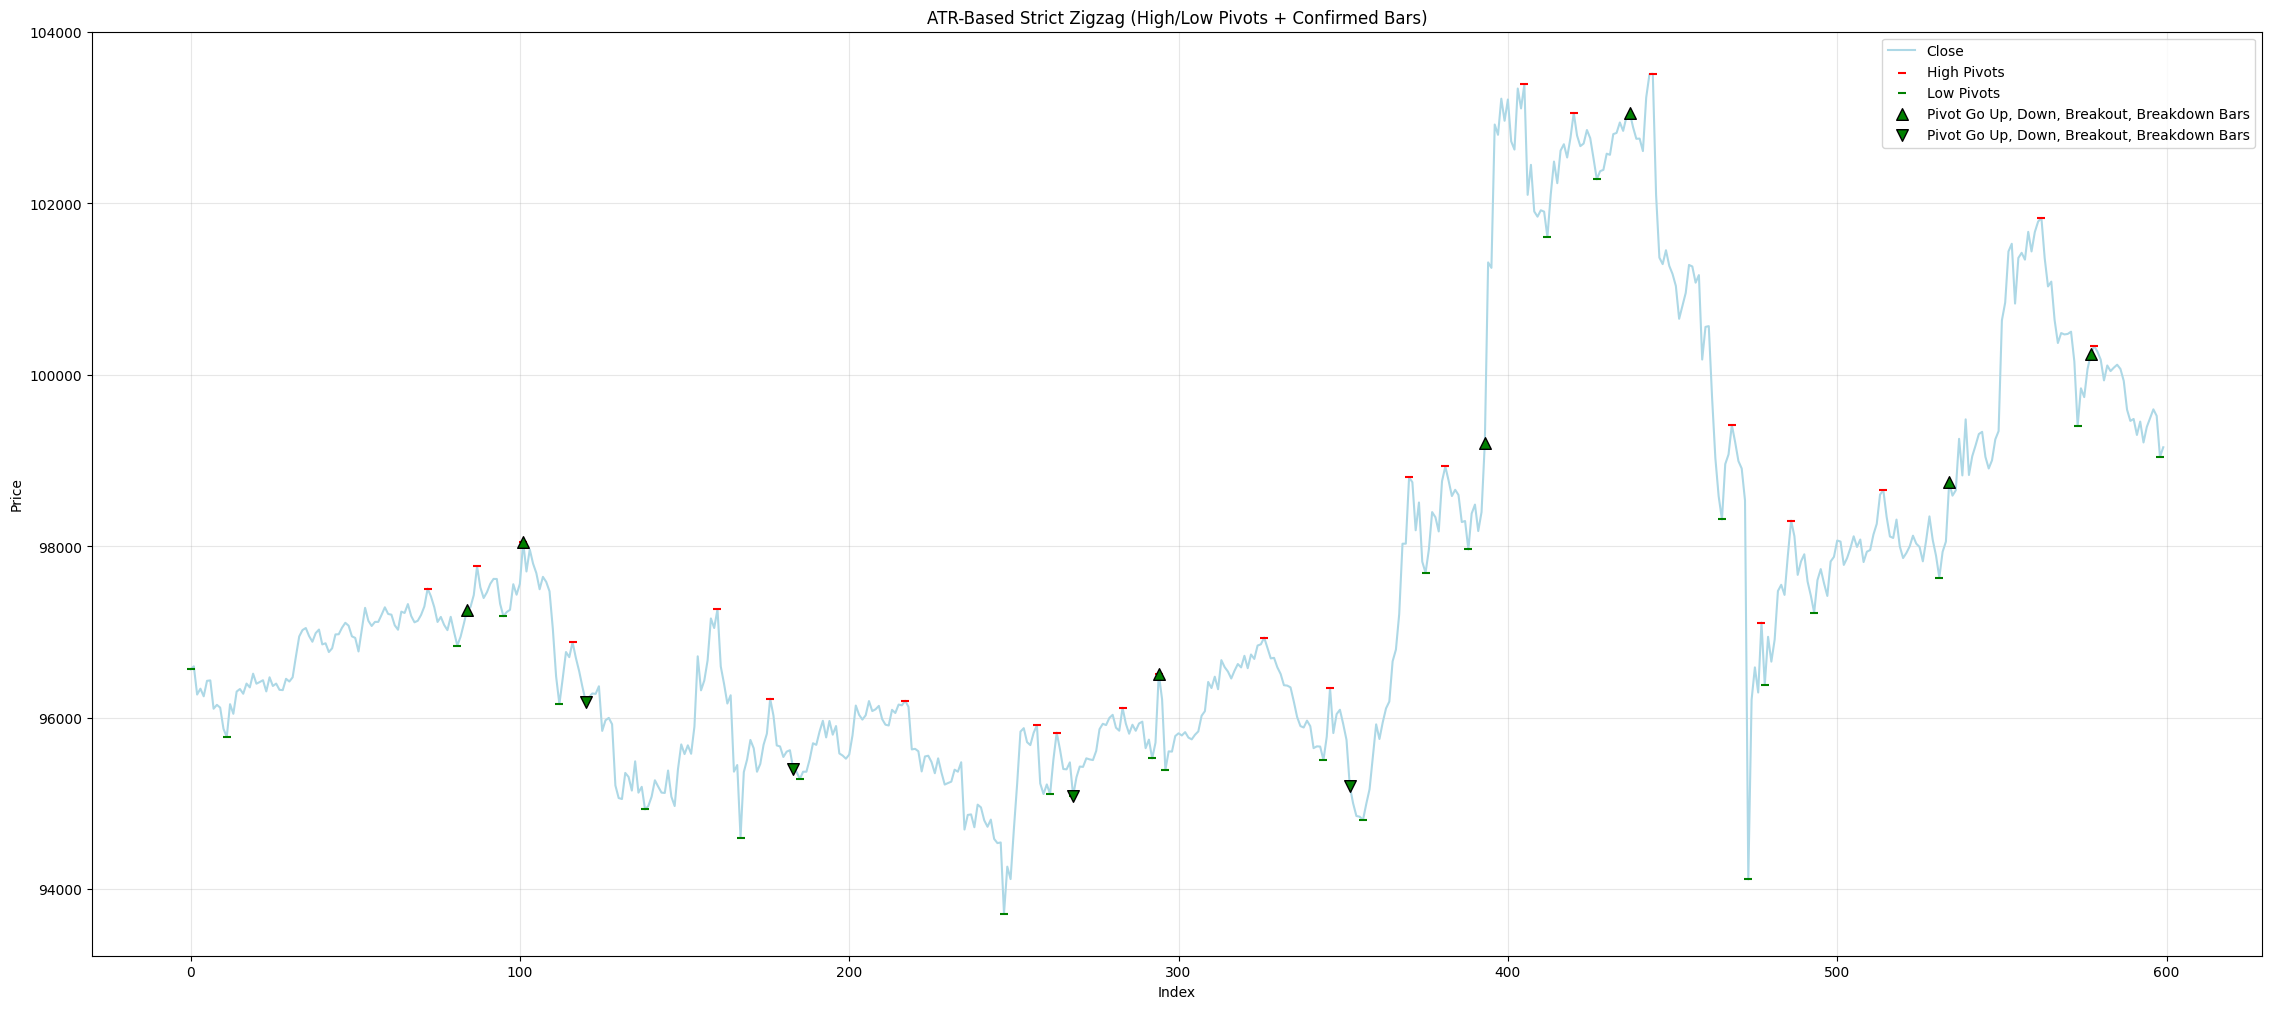

In [33]:
df_z = df[df.index < 600]

plt.figure(figsize=(28,12))
plt.plot(df_z["close"], label="Close", color="lightblue")

plt.scatter(df_z.index, df_z["high_pivot"], color="red", label="High Pivots", zorder=3, marker="_")
plt.scatter(df_z.index, df_z["low_pivot"], color="green", label="Low Pivots", zorder=3, marker="_")

pivot_go = df_z[(df_z["pivot_go_up"] == 1) | (df_z["pivot_go_breakout"] == 1)]
plt.scatter(pivot_go.index, pivot_go["close"], color="green", edgecolors="black",
            label="Pivot Go Up, Down, Breakout, Breakdown Bars", zorder=3, s=70, marker="^")
pivot_go_down = df_z[(df_z["pivot_go_down"] == 1) | (df_z["pivot_go_breakdown"] == 1)]
plt.scatter(pivot_go_down.index, pivot_go_down["close"], color="green", edgecolors="black",
            label="Pivot Go Up, Down, Breakout, Breakdown Bars", zorder=3, s=70, marker="v")
#confirmed = df_z[(df_z["high_pivot_confirmed"] == 1) | (df_z["low_pivot_confirmed"] == 1)]
#plt.scatter(confirmed.index, confirmed["close"], color="yellow", edgecolors="black",
#            label="Confirmed Bars", zorder=1, s=40, marker="o")

plt.title("ATR-Based Strict Zigzag (High/Low Pivots + Confirmed Bars)")
plt.xlabel("Index")
plt.ylabel("Price")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# ATR-Based Fixed Risk Backtest

In [34]:
def atr_backtest(df, long_signal_col, short_signal_col,
                 risk_amount=20, sl_multiplier=3, atr_period=14,
                 initial_capital=10000, round_decimals=3):
    """
    ATR-Based Fixed Risk Backtest

    Parameters:
    -----------
    df: DataFrame with OHLC data
    long_signal_col: column name with True/False for long signals
    short_signal_col: column name with True/False for short signals
    risk_amount: fixed dollar risk per trade (e.g., $20)
    sl_multiplier: SL = entry ± (sl_multiplier * ATR)
    atr_period: ATR calculation period (default 14)
    initial_capital: starting balance
    round_decimals: position size rounding precision

    Returns:
    --------
    trades_df: DataFrame with all trades
    equity_df: DataFrame with equity curve
    """

    # Calculate ATR if not in df
    if 'atr' not in df.columns:
        df['atr'] = calculate_atr(df, period=atr_period)

    # Initialize
    equity = initial_capital
    in_position = False
    position_type = None
    entry_price = 0
    entry_idx = 0
    tp_price = 0
    sl_price = 0
    position_size = 0
    atr_at_entry = 0

    trades = []
    equity_curve = []

    # Loop through data
    for i in range(len(df)):
        row = df.iloc[i]

        # Skip if ATR is NaN
        if pd.isna(row['atr']):
            equity_curve.append(equity)
            continue

        # Check TP/SL if in position
        if in_position:
            if position_type == 'LONG':
                # Check TP (2x risk-reward)
                if row['high'] >= tp_price:
                    pnl = (tp_price - entry_price) * position_size
                    equity += pnl

                    trades.append({
                        'entry_idx': entry_idx,
                        'exit_idx': i,
                        'direction': 'LONG',
                        'entry_price': entry_price,
                        'exit_price': tp_price,
                        'position_size': position_size,
                        'atr': atr_at_entry,
                        'pnl': pnl,
                        'pnl_r': pnl / risk_amount,  # PnL in R multiples
                        'exit_reason': 'TP'
                    })

                    in_position = False
                    continue

                # Check SL
                elif row['low'] <= sl_price:
                    pnl = (sl_price - entry_price) * position_size
                    equity += pnl

                    trades.append({
                        'entry_idx': entry_idx,
                        'exit_idx': i,
                        'direction': 'LONG',
                        'entry_price': entry_price,
                        'exit_price': sl_price,
                        'position_size': position_size,
                        'atr': atr_at_entry,
                        'pnl': pnl,
                        'pnl_r': pnl / risk_amount,
                        'exit_reason': 'SL'
                    })

                    in_position = False
                    continue

            elif position_type == 'SHORT':
                # Check TP
                if row['low'] <= tp_price:
                    pnl = (entry_price - tp_price) * position_size
                    equity += pnl

                    trades.append({
                        'entry_idx': entry_idx,
                        'exit_idx': i,
                        'direction': 'SHORT',
                        'entry_price': entry_price,
                        'exit_price': tp_price,
                        'position_size': position_size,
                        'atr': atr_at_entry,
                        'pnl': pnl,
                        'pnl_r': pnl / risk_amount,
                        'exit_reason': 'TP'
                    })

                    in_position = False
                    continue

                # Check SL
                elif row['high'] >= sl_price:
                    pnl = (entry_price - sl_price) * position_size
                    equity += pnl

                    trades.append({
                        'entry_idx': entry_idx,
                        'exit_idx': i,
                        'direction': 'SHORT',
                        'entry_price': entry_price,
                        'exit_price': sl_price,
                        'position_size': position_size,
                        'atr': atr_at_entry,
                        'pnl': pnl,
                        'pnl_r': pnl / risk_amount,
                        'exit_reason': 'SL'
                    })

                    in_position = False
                    continue

        # Check entry signals if not in position
        if not in_position:
            # Long signal
            if row[long_signal_col]:
                entry_price = row['close']
                atr_at_entry = row['atr']

                # SL = Entry - (sl_multiplier * ATR)
                sl_price = entry_price - (sl_multiplier * atr_at_entry)

                # TP = Entry + (sl_multiplier * ATR)  [1:1 RR]
                tp_price = entry_price + (sl_multiplier * atr_at_entry)

                # Position size = risk_amount / (sl_multiplier * ATR)
                raw_quantity = risk_amount / (sl_multiplier * atr_at_entry)
                position_size = round(raw_quantity, round_decimals)

                if position_size > 0:
                    in_position = True
                    position_type = 'LONG'
                    entry_idx = i

            # Short signal
            elif row[short_signal_col]:
                entry_price = row['close']
                atr_at_entry = row['atr']

                # SL = Entry + (sl_multiplier * ATR)
                sl_price = entry_price + (sl_multiplier * atr_at_entry)

                # TP = Entry - (sl_multiplier * ATR)  [1:1 RR]
                tp_price = entry_price - (sl_multiplier * atr_at_entry)

                # Position size = risk_amount / (sl_multiplier * ATR)
                raw_quantity = risk_amount / (sl_multiplier * atr_at_entry)
                position_size = round(raw_quantity, round_decimals)

                if position_size > 0:
                    in_position = True
                    position_type = 'SHORT'
                    entry_idx = i

        # Record equity
        equity_curve.append(equity)

    # Close final position if still open
    if in_position:
        last_row = df.iloc[-1]
        exit_price = last_row['close']

        if position_type == 'LONG':
            pnl = (exit_price - entry_price) * position_size
        else:
            pnl = (entry_price - exit_price) * position_size

        equity += pnl

        trades.append({
            'entry_idx': entry_idx,
            'exit_idx': len(df)-1,
            'direction': position_type,
            'entry_price': entry_price,
            'exit_price': exit_price,
            'position_size': position_size,
            'atr': atr_at_entry,
            'pnl': pnl,
            'pnl_r': pnl / risk_amount,
            'exit_reason': 'END'
        })

    # Create DataFrames
    trades_df = pd.DataFrame(trades)
    equity_df = pd.DataFrame({'equity': equity_curve})

    return trades_df, equity_df


def print_stats(trades_df, equity_df, initial_capital, risk_amount):
    """Print backtest statistics"""

    if len(trades_df) == 0:
        print("No trades!")
        return

    # Basic stats
    total_trades = len(trades_df)
    wins = len(trades_df[trades_df['pnl'] > 0])
    losses = len(trades_df[trades_df['pnl'] < 0])
    win_rate = wins / total_trades * 100

    # PnL
    total_pnl = trades_df['pnl'].sum()
    final_equity = equity_df['equity'].iloc[-1]
    return_pct = (final_equity - initial_capital) / initial_capital * 100

    # Average
    avg_win = trades_df[trades_df['pnl'] > 0]['pnl'].mean() if wins > 0 else 0
    avg_loss = trades_df[trades_df['pnl'] < 0]['pnl'].mean() if losses > 0 else 0

    # R multiples (how many times risk)
    avg_win_r = trades_df[trades_df['pnl'] > 0]['pnl_r'].mean() if wins > 0 else 0
    avg_loss_r = trades_df[trades_df['pnl'] < 0]['pnl_r'].mean() if losses > 0 else 0

    # Direction stats
    long_trades = len(trades_df[trades_df['direction'] == 'LONG'])
    short_trades = len(trades_df[trades_df['direction'] == 'SHORT'])

    long_wins = len(trades_df[(trades_df['direction'] == 'LONG') & (trades_df['pnl'] > 0)])
    short_wins = len(trades_df[(trades_df['direction'] == 'SHORT') & (trades_df['pnl'] > 0)])

    # Profit factor
    gross_profit = trades_df[trades_df['pnl'] > 0]['pnl'].sum()
    gross_loss = abs(trades_df[trades_df['pnl'] < 0]['pnl'].sum())
    profit_factor = gross_profit / gross_loss if gross_loss > 0 else np.inf

    # Expectancy per trade
    expectancy = trades_df['pnl'].mean()
    expectancy_r = trades_df['pnl_r'].mean()

    print("="*60)
    print("ATR-BASED FIXED RISK BACKTEST RESULTS")
    print("="*60)
    print(f"\n💰 CAPITAL:")
    print(f"  Initial Capital : ${initial_capital:.2f}")
    print(f"  Final Equity    : ${final_equity:.2f}")
    print(f"  Total PnL       : ${total_pnl:.2f}")
    print(f"  Return          : {return_pct:.2f}%")

    print(f"\n📊 TRADE STATISTICS:")
    print(f"  Total Trades    : {total_trades}")
    print(f"  Wins            : {wins} ({win_rate:.1f}%)")
    print(f"  Losses          : {losses} ({100-win_rate:.1f}%)")

    print(f"\n🎯 DIRECTION BREAKDOWN:")
    print(f"  Long Trades     : {long_trades} ({long_wins} wins)")
    print(f"  Short Trades    : {short_trades} ({short_wins} wins)")

    print(f"\n💵 PnL METRICS:")
    print(f"  Avg Win         : ${avg_win:.2f} ({avg_win_r:.2f}R)")
    print(f"  Avg Loss        : ${avg_loss:.2f} ({avg_loss_r:.2f}R)")
    print(f"  Profit Factor   : {profit_factor:.2f}")
    print(f"  Expectancy      : ${expectancy:.2f} ({expectancy_r:.2f}R)")

    print(f"\n⚙️  RISK SETTINGS:")
    print(f"  Risk per Trade  : ${risk_amount:.2f}")
    print(f"  Avg Position    : {trades_df['position_size'].mean():.4f} units")

    print("="*60)


def plot_results(trades_df, equity_df, initial_capital):
    """Plot equity curve and trade PnL"""

    fig, axes = plt.subplots(2, 1, figsize=(14, 8))

    # 1. Equity Curve
    ax1 = axes[0]
    ax1.plot(equity_df.index, equity_df['equity'], linewidth=2, color='blue')
    ax1.axhline(y=initial_capital, color='gray', linestyle='--', alpha=0.5)
    ax1.fill_between(equity_df.index, initial_capital, equity_df['equity'],
                     where=(equity_df['equity'] >= initial_capital),
                     alpha=0.3, color='green')
    ax1.fill_between(equity_df.index, initial_capital, equity_df['equity'],
                     where=(equity_df['equity'] < initial_capital),
                     alpha=0.3, color='red')
    ax1.set_title('Equity Curve', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Equity ($)')
    ax1.grid(True, alpha=0.3)

    # 2. Trade PnL (in R multiples)
    if len(trades_df) > 0:
        ax2 = axes[1]
        colors = ['green' if pnl > 0 else 'red' for pnl in trades_df['pnl']]
        ax2.bar(range(len(trades_df)), trades_df['pnl_r'], color=colors, alpha=0.6)
        ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
        ax2.set_title('Trade PnL (R multiples)', fontsize=14, fontweight='bold')
        ax2.set_xlabel('Trade Number')
        ax2.set_ylabel('PnL (R)')
        ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

ATR-BASED FIXED RISK BACKTEST RESULTS

💰 CAPITAL:
  Initial Capital : $10000.00
  Final Equity    : $10297.12
  Total PnL       : $297.12
  Return          : 2.97%

📊 TRADE STATISTICS:
  Total Trades    : 53
  Wins            : 34 (64.2%)
  Losses          : 19 (35.8%)

🎯 DIRECTION BREAKDOWN:
  Long Trades     : 21 (15 wins)
  Short Trades    : 32 (19 wins)

💵 PnL METRICS:
  Avg Win         : $19.95 (1.00R)
  Avg Loss        : $-20.07 (-1.00R)
  Profit Factor   : 1.78
  Expectancy      : $5.61 (0.28R)

⚙️  RISK SETTINGS:
  Risk per Trade  : $20.00
  Avg Position    : 0.0241 units


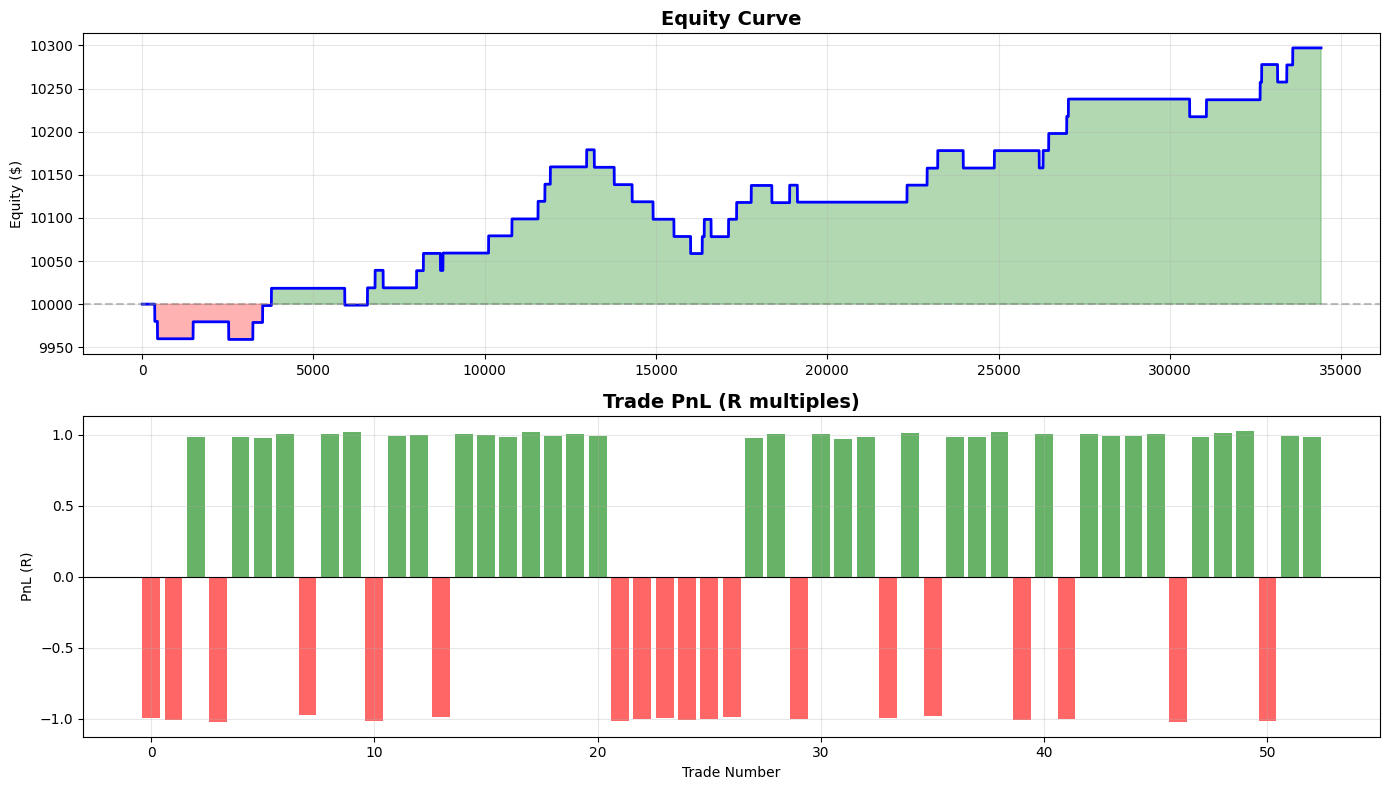


📋 FIRST 10 TRADES:
   entry_idx  exit_idx direction  entry_price     exit_price  position_size  \
0        352       365     SHORT     95203.50   96378.914766          0.017   
1        437       445      LONG    103060.00  101874.064564          0.017   
2       1475      1487     SHORT    104535.44  103681.524219          0.023   
3       2464      2526      LONG     96339.00   94978.034278          0.015   
4       3225      3233      LONG     97084.60   97740.362346          0.030   
5       3515      3519      LONG    100737.03  102043.117242          0.015   
6       3759      3776     SHORT     94027.90   92848.730103          0.017   
7       5842      5919     SHORT    104900.00  105986.616731          0.018   
8       6523      6582      LONG     96959.99   98297.397796          0.015   
9       6805      6806     SHORT     95956.82   95279.177207          0.030   

         pnl     pnl_r exit_reason  
0 -19.982051 -0.999103          SL  
1 -20.160902 -1.008045          SL  

In [37]:
trades_df, equity_df = atr_backtest(
    df=df,
    long_signal_col='pivot_go_breakout',
    short_signal_col='pivot_go_breakdown',
    risk_amount=20,        # $20 risk per trade
    sl_multiplier=3,       # SL = 3 * ATR
    atr_period=14,         # 14-period ATR
    initial_capital=10000,
    round_decimals=3       # Round position size to 3 decimals
)

# Print results
print_stats(trades_df, equity_df, initial_capital=10000, risk_amount=20)

# Plot
plot_results(trades_df, equity_df, initial_capital=10000)

# View trades
print("\n📋 FIRST 10 TRADES:")
print(trades_df.head(10)[['entry_idx', 'exit_idx', 'direction',
                           'entry_price', 'exit_price', 'position_size',
                           'pnl', 'pnl_r', 'exit_reason']])